## Neural Network

In [34]:
# Import all required libraries
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import Dense
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [19]:
# Import feature and target columns
X = pickle.load(open("./common/feature_status.p", "rb"))
y = pickle.load(open("./common/target_status.p", "rb"))
feature_cols = pickle.load(open("./common/feature_cols.p", "rb"))

### Perform Cross Validation

In [35]:
# Define a sklearn-compatible classifier based on our Keras model
class KerasBinaryClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, model):
        self.model = model
    def fit(self, X, y):
        self.model.compile(loss='binary_crossentropy', optimizer='adam')
        self.model.fit(X, y, epochs=150, batch_size=10, verbose=0)
        return self
    def predict(self, X):
        Y_pred = self.model.predict(X)
        Y_pred = (Y_pred >= 0.5).astype(int)
        return Y_pred.flatten()

In [36]:
# Define the Keras model
model = Sequential()
model.add(Dense(12, input_dim=len(feature_cols), activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Wrap it in our sklearn-compatible classifier
clf_cv = KerasBinaryClassifier(model)

# Define metrics
scoring = { 'accuracy': make_scorer(accuracy_score),
            'precision': make_scorer(precision_score),
            'recall': make_scorer(recall_score),
            'F1': make_scorer(f1_score) }

In [37]:
scores = cross_validate(clf_cv, X, y, cv=10, scoring=scoring)

7/7 [==============================] - 0s 1ms/step


In [38]:
# Print scores
for metric_name, score_array in scores.items():
    if metric_name.startswith('test_'):
        print(f'{metric_name}: {score_array.mean():.2f} (+/- {score_array.std() * 2:.2f})')

test_accuracy: 0.94 (+/- 0.04)
test_precision: 0.81 (+/- 0.44)
test_recall: 0.48 (+/- 0.36)
test_F1: 0.58 (+/- 0.37)


### Train the model

In [20]:
# Import training and testing data
X_test = pickle.load(open("./common/metrics_test.p", "rb"))
X_train = pickle.load(open("./common/metrics_train.p", "rb"))
y_test = pickle.load(open("./common/status_test.p", "rb"))
y_train = pickle.load(open("./common/status_train.p", "rb"))

In [39]:
# Define the model
clf = Sequential()
clf.add(Dense(12, input_dim=len(feature_cols), activation='relu'))
clf.add(Dense(8, activation='relu'))
clf.add(Dense(1, activation='sigmoid')) # sigmoid function is used for binary classification

# Compile the model
clf.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'Precision', 'Recall'])

# Train the model
clf.fit(X_train, y_train, epochs=150, batch_size=10, verbose=1)

Epoch 1/150
173/173 [==============================] - 2s 2ms/step - loss: 10.6950 - accuracy: 0.8409 - precision: 0.1726 - recall: 0.2329
Epoch 2/150
173/173 [==============================] - 0s 2ms/step - loss: 3.0278 - accuracy: 0.8073 - precision: 0.2050 - recall: 0.4452
Epoch 3/150
173/173 [==============================] - 0s 2ms/step - loss: 2.1453 - accuracy: 0.8241 - precision: 0.2331 - recall: 0.4726
Epoch 4/150
173/173 [==============================] - 0s 2ms/step - loss: 2.2582 - accuracy: 0.8466 - precision: 0.2836 - recall: 0.5342
Epoch 5/150
173/173 [==============================] - 0s 2ms/step - loss: 1.4667 - accuracy: 0.8634 - precision: 0.3109 - recall: 0.5068
Epoch 6/150
173/173 [==============================] - 1s 3ms/step - loss: 1.3269 - accuracy: 0.8686 - precision: 0.3373 - recall: 0.5753
Epoch 7/150
173/173 [==============================] - 0s 2ms/step - loss: 1.4707 - accuracy: 0.8669 - precision: 0.3293 - recall: 0.5548
Epoch 8/150
173/173 [============

In [40]:
# Use the model to make predictions on the test set
y_pred = clf.predict(X_test)
y_pred = [1 if y >= 0.5 else 0 for y in y_pred]  # threshold

14/14 [==============================] - 0s 2ms/step


In [41]:
# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))

Accuracy: 0.9722863741339491
Precision: 0.8666666666666667
Recall: 0.7647058823529411
F1: 0.8125


### Visualize the model

In [42]:
clf_matrix = confusion_matrix(y_test, y_pred)
clf_matrix

array([[395,   4],
       [  8,  26]], dtype=int64)

Text(0.5, 427.9555555555555, 'Predicted Label')

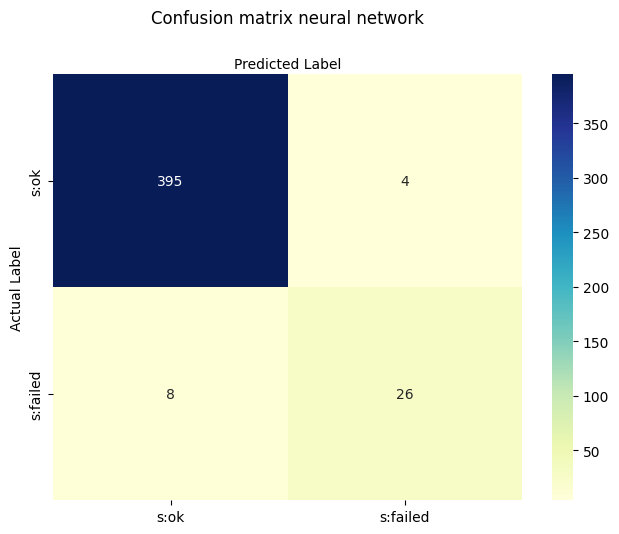

In [43]:
# Assuming clf_matrix is the confusion matrix you've computed
clf_matrix_df = pd.DataFrame(clf_matrix, index=["s:ok", "s:failed"], columns=["s:ok", "s:failed"])

# Create heatmap
class_names=["s:ok", "s:failed"]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))

plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
sns.heatmap(clf_matrix_df, annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")

plt.tight_layout()
plt.title('Confusion matrix neural network', y=1.1)
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')

### Export the model

In [44]:
pickle.dump(clf, open("./models/neural_network.p", "wb"))